### Introduction

In this notebook, I will first take a look at a dataset of selected socioeconomic indicators in Chicago.  
The city of Chicago released this dataset to the Chicago City Portal: https://data.cityofchicago.org/Health-Human-Services/Census-Data-Selected-socioeconomic-indicators-in-C/kn9c-c2s2  
This dataset contains a selection of six socioeconomic indicators of public health significance and a “hardship index,” for each Chicago community area, for the years 2008 – 2012.  
Scores on the hardship index can range from 1 to 100, with a higher index number representing a greater level of hardship.

A detailed description of the dataset can be found on [the city of Chicago's website](https://data.cityofchicago.org/Health-Human-Services/Census-Data-Selected-socioeconomic-indicators-in-C/kn9c-c2s2), but to summarize, the dataset has the following variables:

* **Community Area Number** (`ca`): Used to uniquely identify each row of the dataset

* **Community Area Name** (`community_area_name`): The name of the region in the city of Chicago 

* **Percent of Housing Crowded** (`percent_of_housing_crowded`): Percent of occupied housing units with more than one person per room

* **Percent Households Below Poverty** (`percent_households_below_poverty`): Percent of households living below the federal poverty line

* **Percent Aged 16+ Unemployed** (`percent_aged_16_unemployed`): Percent of persons over the age of 16 years that are unemployed

* **Percent Aged 25+ without High School Diploma** (`percent_aged_25_without_high_school_diploma`): Percent of persons over the age of 25 years without a high school education

* **Percent Aged Under** 18 or Over 64:Percent of population under 18 or over 64 years of age (`percent_aged_under_18_or_over_64`): (ie. dependents)

* **Per Capita Income** (`per_capita_income_`): Community Area per capita income is estimated as the sum of tract-level aggragate incomes divided by the total population

* **Hardship Index** (`hardship_index`): Score that incorporates each of the six selected socioeconomic indicators


Afterwards, I will investigate a dataset, also released by the city of Chicago, showing all school level performance data used to create School Report Cards for the 2011-2012 school year.   
The dataset is available from the Chicago Data Portal: https://data.cityofchicago.org/Education/Chicago-Public-Schools-Progress-Report-Cards-2011-/9xs2-f89t

Finally, I will take a look at Chicago crime data.  
This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days.  
This dataset is quite large - over 1.5GB in size with over 6.5 million rows.   
A detailed description of this dataset and the original dataset can be obtained from the Chicago Data Portal at: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2  
For the purposes of a short investigation in this notebook, I will use a smaller part of this dataset which can be downloaded from: https://ibm.box.com/shared/static/svflyugsr9zbqy5bmowgswqemfpm1x7f.csv

## Chapter I: Chicago socioeconomic data
### Connecting to the database and storing data
Let's establish a connection to the IBM Db2 database:

In [1]:
%load_ext sql

# Remember the connection string is of the format:
# %sql ibm_db_sa://my-username:my-password@my-hostname:my-port/my-db-name
# Enter the connection string for your Db2 on Cloud database instance below
%sql ibm_db_sa://REMOVED:REMOVED@REMOVED:50000/BLUDB

'Connected: mnj99072@BLUDB'

First, I will read the dataset csv file from the internet into pandas dataframe.  
Afterwards, I will create a table in the Db2 database to store the dataset.   
The PERSIST command in SQL "magic" simplifies the process of table creation and writing the data from a pandas dataframe into the table:

In [31]:
import pandas
chicago_socioeconomic_data = pandas.read_csv('https://data.cityofchicago.org/resource/jcxq-k9xf.csv')
%sql drop table chicago_socioeconomic_data
%sql PERSIST chicago_socioeconomic_data

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
(ibm_db_dbi.ProgrammingError) ibm_db_dbi::ProgrammingError: Statement Execute Failed: [IBM][CLI Driver][DB2/LINUXX8664] SQL0204N  "MNJ99072.CHICAGO_SOCIOECONOMIC_DATA" is an undefined name.  SQLSTATE=42704 SQLCODE=-204 [SQL: 'drop table chicago_socioeconomic_data']
 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB


'Persisted chicago_socioeconomic_data'

Let's check whether that worked out:

In [4]:
%sql SELECT * FROM chicago_socioeconomic_data LIMIT 10;

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


index,ca,community_area_name,hardship_index,per_capita_income_,percent_aged_16_unemployed,percent_aged_25_without_high_school_diploma,percent_aged_under_18_or_over_64,percent_households_below_poverty,percent_of_housing_crowded
0,1.0,Rogers Park,39.0,23939,8.7,18.2,27.5,23.6,7.7
1,2.0,West Ridge,46.0,23040,8.8,20.8,38.5,17.2,7.8
2,3.0,Uptown,20.0,35787,8.9,11.8,22.2,24.0,3.8
3,4.0,Lincoln Square,17.0,37524,8.2,13.4,25.5,10.9,3.4
4,5.0,North Center,6.0,57123,5.2,4.5,26.2,7.5,0.3
5,6.0,Lake View,5.0,60058,4.7,2.6,17.0,11.4,1.1
6,7.0,Lincoln Park,2.0,71551,5.1,3.6,21.5,12.3,0.8
7,8.0,Near North Side,1.0,88669,7.0,2.5,22.6,12.9,1.9
8,9.0,Edison Park,8.0,40959,6.5,7.4,35.3,3.3,1.1
9,10.0,Norwood Park,21.0,32875,9.0,11.5,39.5,5.4,2.0


In [5]:
chicago_socioeconomic_data.shape

(78, 9)

### Exploratory data analyis
Let's check how many community area's in Chicago have a hardship index bigger than 50:

In [6]:
%sql select count(*) from chicago_socioeconomic_data where hardship_index > 50;

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


1
38


Which community area has the highest hardship index?

In [7]:
%sql SELECT community_area_name from chicago_socioeconomic_data where hardship_index = 98.0;

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


community_area_name
Riverdale


Which Chicago community areas have per-capita incomes greater than $60,000?

In [8]:
%sql select community_area_name from chicago_socioeconomic_data where per_capita_income_ > 60000;

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


community_area_name
Lake View
Lincoln Park
Near North Side
Loop


Let's create a scatter plot using the columns per_capita_income_ and hardship_index:

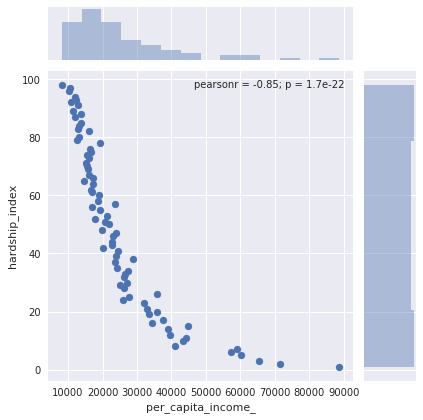

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn; sn.set()

plot = sn.jointplot(x='per_capita_income_',y='hardship_index', data=chicago_socioeconomic_data, kind='scatter')

Apparently, as the per capita income increases, the hardship index decreases.   
We see that the points on the scatter plot are arranged towards a straight line in the negative direction, so we have a negative correlation between the two variables.  
Also, the pearson correlation coefficient of -0.85 is a sign of strong negative correlation.  
The p-value of less than 0.001 shows that the correlation is statistically significant.

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


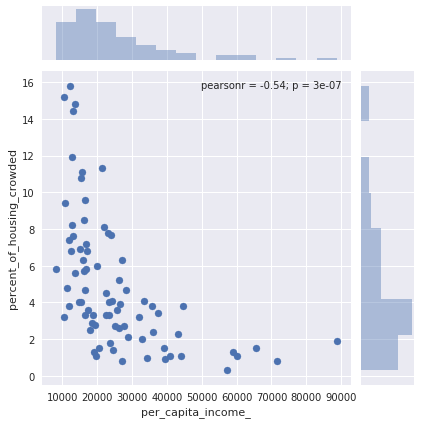

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

income_vs_hardship = %sql SELECT per_capita_income_, percent_of_housing_crowded FROM chicago_socioeconomic_data;
plot = sns.jointplot(x='per_capita_income_',y='percent_of_housing_crowded', data=income_vs_hardship.DataFrame())

Also, there seems to be a moderate negative correlation between the percentage of crowded households and the per_capita_income_.  
The higher the family size, the lower the per_capita_income.  
This is not surprising, because big families have to split their income among several people.

## Chapter II: Chicago public progress report cards
### Downloading the datafile
I downloaded the data file from the City of Chicago data storage.  
The csv file can be accessed here: https://ibm.box.com/shared/static/0g7kbanvn5l2gt2qu38ukooatnjqyuys.csv  
After storing it in the IBM Db2 database warehouse, let's check if it is accessible by querying the database system catalog to retrieve table metadata:

In [37]:
# query to retrieve list of all tables in the database
%sql select TABSCHEMA, TABNAME, CREATE_TIME from syscat.tables where tabschema='MNJ99072';

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


tabschema,tabname,create_time
MNJ99072,CHICAGO_CRIME_DATA,2018-10-30 11:15:21.038280
MNJ99072,EMPLOYEES,2018-10-29 14:35:28.814308
MNJ99072,JOB_HISTORY,2018-10-29 14:35:29.027256
MNJ99072,JOBS,2018-10-29 14:35:29.225604
MNJ99072,DEPARTMENTS,2018-10-29 14:35:29.421177
MNJ99072,LOCATIONS,2018-10-29 14:35:29.614347
MNJ99072,INSTRUCTOR,2018-11-24 16:22:26.267762
MNJ99072,INTERNATIONAL_STUDENT_TEST_SCORES,2018-11-24 16:34:41.326733
MNJ99072,CHICAGO_SOCIOECONOMIC_DATA,2018-11-24 17:56:23.373526
MNJ99072,SCHOOLS,2018-11-24 18:02:20.431628


In [38]:
# query to retrieve the number of columns in the SCHOOLS table
%sql select count(*) from syscat.columns where tabname = 'SCHOOLS';

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


1
79


Let's retrieve the list of columns in the SCHOOLS table and their column type (datatype) and length:

In [39]:
# uery to retrieve all column names in the SCHOOLS table along with their datatypes and length
%sql select COLNAME, TYPENAME, LENGTH from SYSCAT.COLUMNS where TABNAME = 'SCHOOLS';

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


colname,typename,length
11th Grade Average ACT (2011),VARCHAR,4
Net_Change_PLAN_and_ACT,VARCHAR,3
College_Eligibility__,VARCHAR,4
Graduation_Rate__,VARCHAR,4
College_Enrollment_Rate__,VARCHAR,4
College_Enrollment__number_of_students_,SMALLINT,2
General_Services_Route,SMALLINT,2
Freshman_on_Track_Rate__,VARCHAR,4
RCDTS_Code,BIGINT,8
X_COORDINATE,DECIMAL,13


### Exploratory data analysis
Let's check how many elementary schools there are in the dataset:

In [40]:
%sql select count(*) from SCHOOLS where "Elementary, Middle, or High School" = 'ES';

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


1
462


What is the highest Safety Score?

In [41]:
%sql select Max("Safety_Score") from SCHOOLS;

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


1
99


Which schools have the highest Safety Score?

In [22]:
%sql select "Name_of_School" from SCHOOLS where "Safety_Score" = 99;

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


Name_of_School
Abraham Lincoln Elementary School
Alexander Graham Bell Elementary School
Annie Keller Elementary Gifted Magnet School
Augustus H Burley Elementary School
Edgar Allan Poe Elementary Classical School
Edgebrook Elementary School
Ellen Mitchell Elementary School
James E McDade Elementary Classical School
James G Blaine Elementary School
LaSalle Elementary Language Academy


What are the top 10 schools with the highest "Average Student Attendance"?

In [23]:
%sql select "Name_of_School", "Average_Student_Attendance" from SCHOOLS order by "Average_Student_Attendance" DESC nulls last limit 10;

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


Name_of_School,Average_Student_Attendance
John Charles Haines Elementary School,98.4%
James Ward Elementary School,97.8%
Edgar Allan Poe Elementary Classical School,97.6%
Orozco Fine Arts & Sciences Elementary School,97.6%
Rachel Carson Elementary School,97.6%
Annie Keller Elementary Gifted Magnet School,97.5%
Andrew Jackson Elementary Language Academy,97.4%
Lenart Elementary Regional Gifted Center,97.4%
Disney II Magnet School,97.3%
John H Vanderpoel Elementary Magnet School,97.2%


Let's retrieve the list of 5 schools with the lowest Average Student Attendance sorted in ascending order based on attendance:

In [24]:
%sql select "Name_of_School", "Average_Student_Attendance" from SCHOOLS order by "Average_Student_Attendance" fetch first 5 rows only;

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


Name_of_School,Average_Student_Attendance
Richard T Crane Technical Preparatory High School,57.9%
Barbara Vick Early Childhood & Family Center,60.9%
Dyett High School,62.5%
Wendell Phillips Academy High School,63.0%
Orr Academy High School,66.3%


Now, let's remove the '%' sign from the above result set for Average Student Attendance column:

In [25]:
%sql select "Name_of_School", REPLACE("Average_Student_Attendance", '%', '') from SCHOOLS order by "Average_Student_Attendance" fetch first 5 rows only;

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


Name_of_School,2
Richard T Crane Technical Preparatory High School,57.9
Barbara Vick Early Childhood & Family Center,60.9
Dyett High School,62.5
Wendell Phillips Academy High School,63.0
Orr Academy High School,66.3


Which Schools have Average Student Attendance lower than 70%?

In [26]:
%sql select "Name_of_School", REPLACE("Average_Student_Attendance", '%', '') from SCHOOLS order by "Average_Student_Attendance" fetch first 5 rows only;

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


Name_of_School,2
Richard T Crane Technical Preparatory High School,57.9
Barbara Vick Early Childhood & Family Center,60.9
Dyett High School,62.5
Wendell Phillips Academy High School,63.0
Orr Academy High School,66.3


Let's get the total College Enrollment (number of students) for each Community Area:

In [27]:
%sql select "Community_Area_Name", sum("College_Enrollment__number_of_students_") AS TOTAL_ENROLLMENT from SCHOOLS group by "Community_Area_Name";

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


Community_Area_Name,total_enrollment
ALBANY PARK,6864
ARCHER HEIGHTS,4823
ARMOUR SQUARE,1458
ASHBURN,6483
AUBURN GRESHAM,4175
AUSTIN,10933
AVALON PARK,1522
AVONDALE,3640
BELMONT CRAGIN,14386
BEVERLY,1636


Let's get the 5 Community Areas with the least total College Enrollment (number of students) sorted in ascending order:

In [28]:
%sql select "Community_Area_Name", sum("College_Enrollment__number_of_students_") AS TOTAL_ENROLLMENT from SCHOOLS group by "Community_Area_Name" order by TOTAL_ENROLLMENT limit 5;

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


Community_Area_Name,total_enrollment
OAKLAND,140
FULLER PARK,531
BURNSIDE,549
OHARE,786
LOOP,871


## Chapter III: Working with all three datasets, including Chicago crime data
### Downloading the Chicago crime datafile
I downloaded the crime data file from the City of Chicago data storage.
The csv file can be accessed here: https://ibm.box.com/shared/static/svflyugsr9zbqy5bmowgswqemfpm1x7f.csv  
After storing it in the IBM Db2 database warehouse, let's check if it is accessible by querying the database system catalog to retrieve table metadata:

In [42]:
# query to retrieve list of all tables in the database
%sql select TABSCHEMA, TABNAME, CREATE_TIME from syscat.tables where tabschema='MNJ99072';

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


tabschema,tabname,create_time
MNJ99072,CHICAGO_CRIME_DATA,2018-10-30 11:15:21.038280
MNJ99072,EMPLOYEES,2018-10-29 14:35:28.814308
MNJ99072,JOB_HISTORY,2018-10-29 14:35:29.027256
MNJ99072,JOBS,2018-10-29 14:35:29.225604
MNJ99072,DEPARTMENTS,2018-10-29 14:35:29.421177
MNJ99072,LOCATIONS,2018-10-29 14:35:29.614347
MNJ99072,INSTRUCTOR,2018-11-24 16:22:26.267762
MNJ99072,INTERNATIONAL_STUDENT_TEST_SCORES,2018-11-24 16:34:41.326733
MNJ99072,CHICAGO_SOCIOECONOMIC_DATA,2018-11-24 17:56:23.373526
MNJ99072,SCHOOLS,2018-11-24 18:02:20.431628


### Exploratory data analysis
Let's check the size of all three stored tables:

In [45]:
# Rows in Census Data (Socieconimic Indicators)
%sql select count(*) from CHICAGO_SOCIOECONOMIC_DATA;

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


1
78


In [46]:
# Rows in Public Schools
%sql select count(*) from SCHOOLS;

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


1
566


In [47]:
# Rows in Crime Data
%sql select count(*) from CHICAGO_CRIME_DATA;

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


1
533


Let's find the average college enrollments by community area:

In [48]:
%sql select "Community_Area_Name", avg("College_Enrollment__number_of_students_") AS AVG_ENROLLMENT from SCHOOLS group by "Community_Area_Name";

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


Community_Area_Name,avg_enrollment
ALBANY PARK,858.000000
ARCHER HEIGHTS,2411.500000
ARMOUR SQUARE,486.000000
ASHBURN,810.375000
AUBURN GRESHAM,417.500000
AUSTIN,475.347826
AVALON PARK,507.333333
AVONDALE,910.000000
BELMONT CRAGIN,1198.833333
BEVERLY,409.000000


Let's find the number of schools that are healthy school certified:

In [49]:
%sql select count(*) from SCHOOLS where "Healthy_Schools_Certified_" = TRUE;

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


1
16


How many observations in the crime data have a Location Description value of GAS STATION?

In [50]:
%sql select count(*) from CHICAGO_CRIME_DATA where "Location_Description" = 'GAS STATION';

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


1
6


Let's retrieve a list of the top 10 community areas which have most number of schools and sorted in descending order:

In [51]:
%sql select "Community_Area_Name", count("Community_Area_Name") AS NUMBER_OF_SCHOOLS from SCHOOLS group by "Community_Area_Name" order by NUMBER_OF_SCHOOLS DESC limit 10;

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


Community_Area_Name,number_of_schools
AUSTIN,23
SOUTH LAWNDALE,22
WEST TOWN,20
ENGLEWOOD,17
NEAR WEST SIDE,16
NORTH LAWNDALE,16
EAST GARFIELD PARK,13
ROSELAND,13
NEW CITY,13
HUMBOLDT PARK,13


How many observations have value MOTOR VEHICLE THEFT in the Primary Type variable (this is the number of crimes related to Motor vehicles)?

In [52]:
%sql select count(*) from CHICAGO_CRIME_DATA where "Primary_Type" = 'MOTOR VEHICLE THEFT';

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


1
24


Let's find the minimum “Average Student Attendance” for community are where hardship is 96:

In [53]:
%sql select S."Community_Area_Name" ,S."Average_Student_Attendance", CSD.hardship_index from SCHOOLS as S \
INNER JOIN CHICAGO_SOCIOECONOMIC_DATA as CSD on S."Community_Area_Name" = UPPER(CSD.community_area_name) \
where CSD.hardship_index = 96 order by DECIMAL(REPLACE(S."Average_Student_Attendance", '%', '')) limit 1;  

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


Community_Area_Name,Average_Student_Attendance,hardship_index
SOUTH LAWNDALE,86.1%,96.0
